In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='bert-base-uncased'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 4
lr = 1.0e-4
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search bert-base-uncased, learning rate 0.0001, focal loss gamma 4, weight decay 0.1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0853	Val Loss:	0.6082	Accuracy:	0.7484	F1:	0.7161
2 / 30: Train Loss:	0.0600	Val Loss:	0.4755	Accuracy:	0.8359	F1:	0.7608
3 / 30: Train Loss:	0.0449	Val Loss:	0.4224	Accuracy:	0.8206	F1:	0.7645
4 / 30: Train Loss:	0.0340	Val Loss:	0.5048	Accuracy:	0.8578	F1:	0.8023
5 / 30: Train Loss:	0.0190	Val Loss:	0.5972	Accuracy:	0.6433	F1:	0.6309
6 / 30: Train Loss:	0.0140	Val Loss:	0.4132	Accuracy:	0.8249	F1:	0.7740
7 / 30: Train Loss:	0.0138	Val Loss:	0.4277	Accuracy:	0.8118	F1:	0.7324
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.78      0.63      0.70       119
      struct       0.88      0.94      0.91       338

    accuracy                           0.86       457
   macro avg       0.83      0.78      0.80       457
weighted avg       0.85      0.86      0.85       457

test results:
              precision    recall  f1-score   support

       bknow

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0846	Val Loss:	0.6342	Accuracy:	0.7002	F1:	0.6788
2 / 30: Train Loss:	0.0543	Val Loss:	0.4977	Accuracy:	0.8534	F1:	0.7949
3 / 30: Train Loss:	0.0509	Val Loss:	0.5017	Accuracy:	0.7724	F1:	0.7354
4 / 30: Train Loss:	0.0289	Val Loss:	0.4921	Accuracy:	0.7856	F1:	0.7413
5 / 30: Train Loss:	0.0315	Val Loss:	0.6486	Accuracy:	0.6346	F1:	0.6263
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.78      0.61      0.69       119
      struct       0.87      0.94      0.90       338

    accuracy                           0.85       457
   macro avg       0.82      0.78      0.79       457
weighted avg       0.85      0.85      0.85       457

test results:
              precision    recall  f1-score   support

       bknow       0.74      0.60      0.66        67
      struct       0.87      0.93      0.90       189

    accuracy                           0.84    

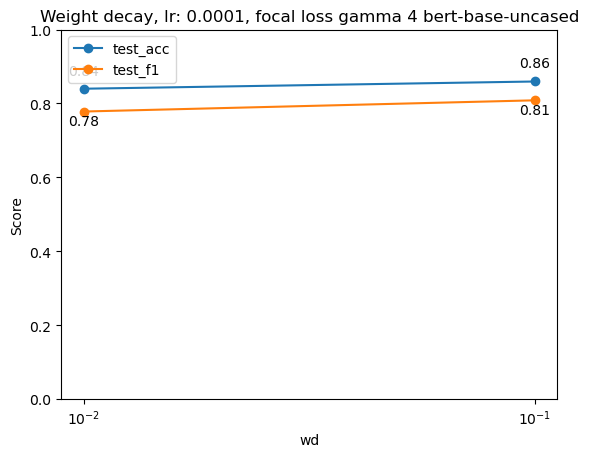

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f